In [1]:
import yfinance as yf

C:\Users\Anri Wang\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import numpy as np
import pandas as pd

In [3]:
sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(period = 'max')
sp500.index = sp500.index.tz_localize(None)
sp500 = sp500[(sp500[['Volume']] != 0).all(axis=1)]

sp500.head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1950-01-03,16.66,16.66,16.66,16.66,1260000,0.0,0.0
1950-01-04,16.85,16.85,16.85,16.85,1890000,0.0,0.0
1950-01-05,16.93,16.93,16.93,16.93,2550000,0.0,0.0
1950-01-06,16.98,16.98,16.98,16.98,2010000,0.0,0.0
1950-01-09,17.08,17.08,17.08,17.08,2520000,0.0,0.0


<Axes: xlabel='Date'>

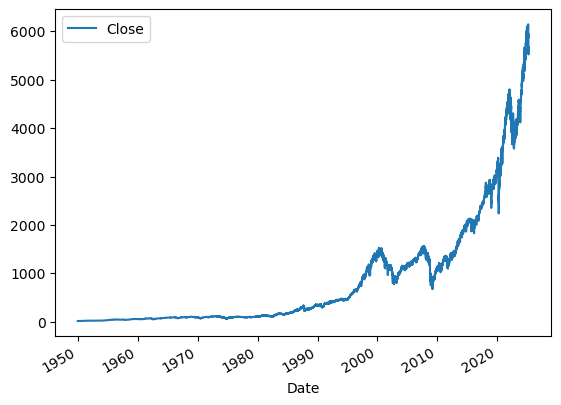

In [4]:
sp500.plot.line(y = 'Close', use_index = True)

In [5]:
del sp500['Dividends']
del sp500['Stock Splits']

In [6]:
sp500['Tomorrow'] = sp500['Close'].shift(-1).round(2)
sp500['Target'] = np.where(sp500['Tomorrow'] > sp500['Close'], 1, 0)
sp500 = sp500.loc['1990-01-01':].copy()
sp500.head()

,Open,High,Low,Close,Volume,Tomorrow,Target
Date,,,,,,,
1990-01-02,353.399994,359.690002,351.980011,359.690002,162070000,358.76,0
1990-01-03,359.690002,360.589996,357.890015,358.760010,192330000,355.67,0
1990-01-04,358.760010,358.760010,352.890015,355.670013,177000000,352.20,0
1990-01-05,355.670013,355.670013,351.350006,352.200012,158530000,353.79,1
1990-01-08,352.200012,354.239990,350.540009,353.790009,140110000,349.62,0


In [7]:
sp500.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Tomorrow', 'Target'], dtype='object')

In [8]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators = 100, min_samples_split = 100, random_state=1)

train = sp500.iloc[:-100]
test = sp500.iloc[-100:]

predictors = ['Open', 'High', 'Low', 'Close', 'Volume']
model.fit(train[predictors], train['Target'])

RandomForestClassifier(min_samples_split=100, random_state=1)

In [9]:
from sklearn.metrics import precision_score

preds = model.predict(test[predictors])
preds = pd.Series(preds, index = test.index)
print(preds)

precision_score(test['Target'], preds)

Date
2024-10-25    1
2024-10-28    1
2024-10-29    0
2024-10-30    1
2024-10-31    1
             ..
2025-03-17    0
2025-03-18    0
2025-03-19    0
2025-03-20    0
2025-03-21    1
Length: 100, dtype: int32


0.7

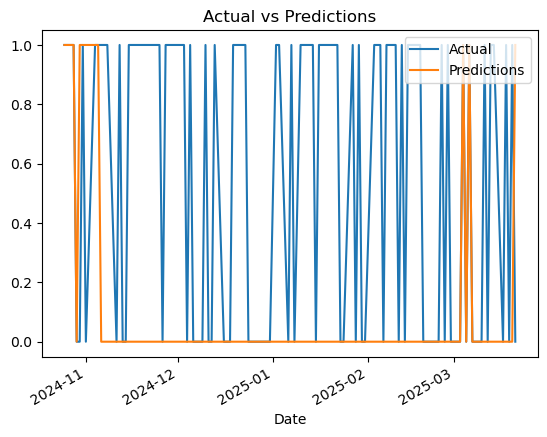

In [10]:
preds = preds.rename('Predictions')
combined = pd.concat([test['Target'].rename('Actual'), preds], axis = 1)

ax = combined.plot(title="Actual vs Predictions")  
ax.legend(loc="upper right")

## build a backtesting system

In [11]:
horizons = [2,5,60,250,1000]
new_predictors = []

for horizon in horizons:
    rolling_averages = sp500['Close'].rolling(horizon).mean()
    
    ratio_column = f'Close_Ratio_{horizon}'
    sp500[ratio_column] = sp500['Close'] / rolling_averages
    
    trend_column = f'Trend_{horizon}'
    sp500[trend_column] = sp500.shift(1).rolling(horizon).sum()['Target']
    
    new_predictors += [ratio_column, trend_column]

In [17]:
sp500 = sp500.dropna()

In [18]:
model = RandomForestClassifier(n_estimators = 200, min_samples_split = 50, random_state=1)

In [19]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['Target'])
    preds = model.predict_proba(test[predictors])[:,1]
    preds[preds >= .6] = 1
    preds[preds < .6] = 0
    preds = pd.Series(preds, index = test.index, name = 'Predictions')
    combined = pd.concat([test['Target'], preds], axis = 1).dropna()
    return combined

In [20]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions = []
    
    for i in range(start, data.shape[0], step):
        train = data.iloc[0:i].copy()
        test = data.iloc[i:(i+step)].copy()
        predictions = predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [21]:
predictions = backtest(sp500, model, new_predictors)
precision_score(predictions['Target'], predictions['Predictions'])

0.5738831615120275